### Imports

In [136]:
from astropy import units as u
from astropy.coordinates import SkyCoord
from sklearn.neighbors import NearestNeighbors
import scipy as sp
from scipy.spatial import distance
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mpl_scatter_density 
from matplotlib.colors import LinearSegmentedColormap
from scipy.optimize import curve_fit
from sklearn.mixture import GaussianMixture
import networkx as nx
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize, StandardScaler


import warnings
warnings.filterwarnings('ignore')

### Functions

In [137]:
def preprocess_cluster(data, g_mean_th=19):
    """
    ------
    parallax > 0 

    phot_g_mean_mag < g_mean_th
    ------
    """
    data = data[data['parallax'] > 0]
    data = data[data['phot_g_mean_mag'] < g_mean_th]
    data['Gmg'] = data['phot_g_mean_mag'] + (5 * np.log10(data['parallax']) - 10)
    data['L'] = 10**(0.4*(4.83 - data['Gmg']))
    data = data[(abs(data['pmra']) < 10) & (abs(data['pmdec']) < 10)]
    print(len(data))
    return data


def cmd_plot(data, x_axis, y_axis, alpha=0.8, s=5):
    """
    -------
    plot isochrone
    -------
    """

    with plt.style.context(['ieee']):
        fig = plt.figure(figsize=(6,4), dpi=100)
        sns.scatterplot(data=data, y=y_axis, x=x_axis, alpha=alpha, s=s)
        plt.gca().invert_yaxis();
        
        
def joint_plot(data):

    plt.figure(dpi=90)
    sns.jointplot(
        data=data,
        x="pmra", y="pmdec",
        kind="kde"
        )
    plt.show()
    
    
def fit_curve(data, column, bins = 100):

    plt.figure(figsize=(8,2), dpi=80)
    counts, bins, patches = plt.hist(data[column], bins = bins)

    # Define the Gaussian function
    def gaussian(x, amp, mu, sigma):
        return amp * np.exp(-(x - mu)**2 / (2 * sigma**2))
    
    # data
    x_data = bins[:-1]
    y_data = counts
    
    # Fit the Gaussian function to the data
    popt, pcov = curve_fit(gaussian, x_data, y_data, maxfev=5000)
    
    plt.figure(figsize=(8,2), dpi=80)
    # Plot the original data and the fitted curve
    sns.scatterplot(x_data, y_data, label=column)
    plt.plot(x_data, gaussian(x_data, *popt), color='red', label='Fit')
    plt.legend()
    plt.show()
    
    return popt


def guassian_filter(data, column, mu, std):    
    up = round(mu + 3 * std, 2)
    low = round(mu - 3 * std, 2)
    
    if up > low:
        print(f'{column} upper bound:', up) 
        print(f'{column} lower bound:', low)
        df = data[(data[column] < up) & (data[column] > low)]
    else:
        print(f'{column} upper bound:', low) 
        print(f'{column} lower bound:', up)
        df = data[(data[column]< low) & (data[column] > up)]
    
    print('cluster length:', len(df))
    return df


def luminosity_density(cluster_3d, clusterdf):
    """
    --------
    cluster_3d --> measuring distance in that dataframe
    
    clusterdf --> main dataframe
    -------
    """
    # create a NearestNeighbors object and fit the dataset
    nbrs = NearestNeighbors(n_neighbors=6, metric='minkowski').fit(cluster_3d)

    # find the 5 nearest neighbors for each data point including itself
    distances, indices = nbrs.kneighbors(cluster_3d)

    # find maximum distance among 5 neighbors
    max_distances = np.amax(distances, axis=1)

    # sphere of that max distance
    spheres = (4/3) * np.pi * (max_distances ** 3)

    # sum of luminosities of each 6 nn
    lum_sum = []
    for i in range(len(clusterdf)):
        lum_sum.append(np.sum(clusterdf.iloc[indices[i]]['L']))

    # luminosity density
    lum_dens = lum_sum / spheres

    return lum_dens



def lum_plot(data):
    """
    --------
    plot for luminosity density profile
    --------
    """    
    
    with plt.style.context(['ieee']):
        plt.figure(figsize=(12,6), dpi=200)
        plt.plot(range(len(data)), np.sort(data))
        plt.ylabel('ΔL/ΔV')
        plt.title('luminosity density profile');
        
def min_span_tree(df_data, num_std = 1, threshold=.85, manual_th=True):
    
    np.random.seed(101)
    
    df_data = df_data.reset_index().drop('index', axis=1)
    data = df_data.copy()
    scaler = StandardScaler()
    data[['r_med_photogeo', 'ra', 'dec']] = scaler.fit_transform(data[['r_med_photogeo', 'ra', 'dec']])
    
    nn = NearestNeighbors(n_neighbors=3, metric='minkowski')
    nn.fit(data[['r_med_photogeo', 'ra', 'dec']])
    distances, indices = nn.kneighbors(data[['r_med_photogeo', 'ra', 'dec']])

    # Create an empty graph
    G = nx.Graph()

    # Add edges with distances to the graph
    n_samples = data.shape[0]
    for i in range(n_samples):
        for j in range(1, len(indices[i])):
            neighbor_index = indices[i, j]
            weight = distances[i, j]
            G.add_edge(i, neighbor_index, weight=weight)

    # Compute the minimum spanning tree
    mst = nx.minimum_spanning_tree(G)

    # Weight of the MST
    edge_weights = [X['weight'] for _, _, X in mst.edges(data=True)]
    
    if manual_th: # use threshold to filter
        # Sort the edge weights in ascending order
        sorted_weights = sorted(edge_weights)

        # Plot sorted edge weights
        plt.figure(figsize=(4,2))
        plt.plot(sorted_weights)
        plt.hlines(threshold, 0,len(df_data), colors='red')
        plt.xlabel('Edge Index')
        plt.ylabel('Edge Weight')
        plt.title('Sorted Edge Weights')
        plt.show()
    
    else:
        threshold = np.mean(edge_weights) + num_std * np.std(edge_weights)
        print('threshold:', round(threshold, 2))
    
    # Identify the nodes with weights greater than the mean weight
    nodes_to_remove = [node for node in mst.nodes() if mst.degree(node, weight='weight') > threshold]

    # Remove the identified nodes from the MST
    mst.remove_nodes_from(nodes_to_remove)

    df_data['MST_cluster'] = 1
    df_data.loc[nodes_to_remove, 'MST_cluster'] = 0
    
    return df_data

### DATA

In [138]:
df_Collinder_69  = pd.read_csv('../../data/Collinder 69-result.csv')
df_Collinder_69_members = pd.read_excel('Collinder_69_members.xlsx')

### preprocess

In [139]:
df_Collinder_69 = preprocess_cluster(df_Collinder_69, g_mean_th=19)

113946


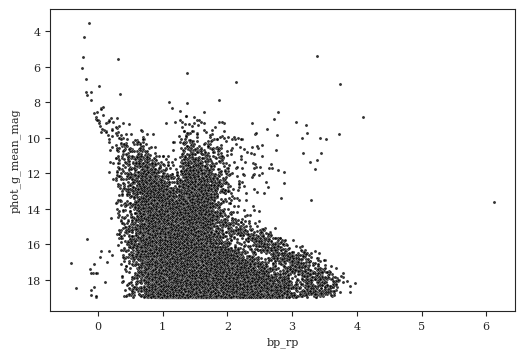

In [140]:
cmd_plot(df_Collinder_69, 'bp_rp', 'phot_g_mean_mag')

In [141]:
df_Collinder_69.columns

Index(['source_id', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax',
       'parallax_error', 'pmra', 'pmdec', 'phot_g_mean_mag', 'bp_rp', 'bp_g',
       'g_rp', 'radial_velocity', 'phot_variable_flag', 'l', 'b',
       'teff_gspphot', 'distance_gspphot', 'azero_gspphot', 'ag_gspphot',
       'ebpminrp_gspphot', 'r_med_geo', 'r_med_photogeo', 'Gmg', 'L'],
      dtype='object')

    Collinder 69  
        Proper motions (mas/yr) : 1.194 -2.11  
        Parallaxes (mas):	    2.462

### Filters

In [144]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj] # print name of variable

def guassian_fit_filter(data, parameter, num_bins=80):
    print('\n',namestr(data, globals())[0])
    amp, mu, std = fit_curve(data, parameter, bins=num_bins)
    return guassian_filter(data, parameter, mu, std)

In [145]:
def drop_columns(data):
    return data.drop(['source_id', 'ra_error', 'dec_error',
                      'parallax_error', 'radial_velocity',
                      'phot_variable_flag', 'l', 'b', 'teff_gspphot', 
                      'distance_gspphot', 'azero_gspphot', 'ag_gspphot',
                      'ebpminrp_gspphot', 'r_med_geo', 'L'], axis=1).dropna(axis=0)

In [146]:
# Initial Filter on PMRA and PMDEC 

def filter_proper_motion(data, pmra, pmdec, d_pmra=1, d_pmdec=1.2):
    return data[(abs(data['pmra'] - pmra) < d_pmra) & (abs(data['pmdec'] - pmdec) < d_pmdec)]

def filter_parallax(data, parallax, delta = 0.2):
    return data[(abs(data['parallax'] - parallax) < delta)]

### Guassian Filters

In [147]:
sns.set_style('ticks')

In [148]:
df_Collinder_69_new = drop_columns(df_Collinder_69)
df_Collinder_69_new = filter_proper_motion(df_Collinder_69_new, 1.194, -2.11, 1.5)
df_Collinder_69_new = filter_parallax(df_Collinder_69_new, 2.462, 0.5)


 df_Collinder_69_new


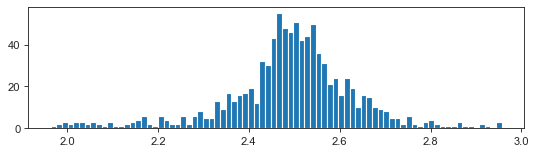

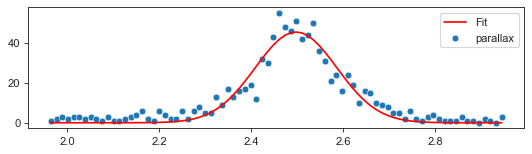

parallax upper bound: 2.76
parallax lower bound: 2.23
cluster length: 850

 df_Collinder_69_new


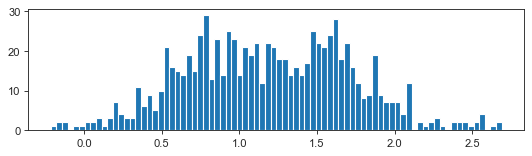

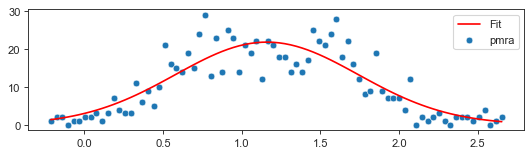

pmra upper bound: 2.9
pmra lower bound: -0.58
cluster length: 850

 df_Collinder_69_new


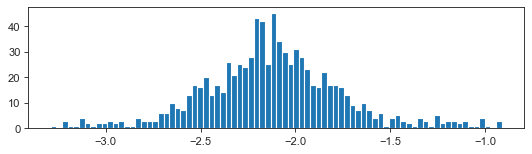

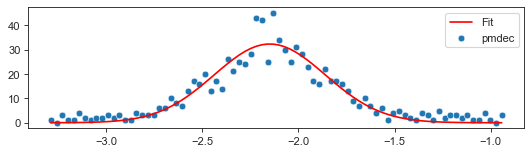

pmdec upper bound: -1.28
pmdec lower bound: -3.02
cluster length: 807


In [149]:
df_Collinder_69_new = guassian_fit_filter(df_Collinder_69_new, 'parallax')
df_Collinder_69_new = guassian_fit_filter(df_Collinder_69_new, 'pmra')
df_Collinder_69_new = guassian_fit_filter(df_Collinder_69_new, 'pmdec')

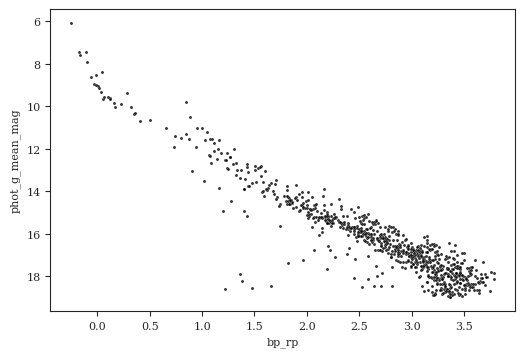

In [150]:
cmd_plot(df_Collinder_69_new, 'bp_rp', 'phot_g_mean_mag')

### Guassina Mixture Model

In [151]:
# params = ['pmra', 'pmdec', 'parallax']

def gassian_mixture(data, parameters = ['pmra', 'pmdec', 'parallax', 'r_med_photogeo', 'ra', 'dec']):
    np.random.seed(101)
    gm = GaussianMixture(n_components=2, random_state=101)
    
    y_pred = gm.fit_predict(data[parameters])
    y_prob = gm.predict_proba(data[parameters])
    
    data['cluster'] = y_pred
    data['prob'] = np.amax(y_prob,axis=1)
    return data, gm

In [152]:
df_Collinder_69_new, _ = gassian_mixture(df_Collinder_69_new)

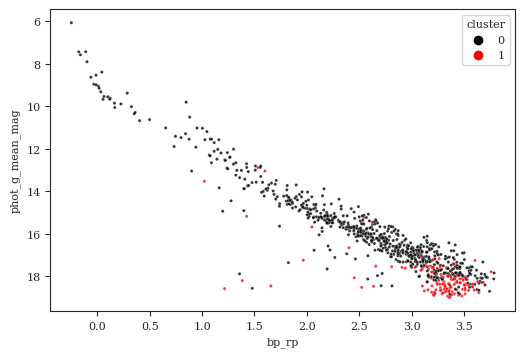

In [153]:
def cmd_plotly(data, x_axis, y_axis, huex = 'cluster', ax=None, alpha=0.8, s=8):
    """
    -------
    plot isochrone
    -------
    """
    with plt.style.context(['ieee']):
        if ax is None:
            fig = plt.figure(figsize=(6,4), dpi=100)
            ax = fig.add_subplot(111)
        sns.scatterplot(data=data, y=y_axis, x=x_axis, alpha=alpha, s=s, hue = huex, ax=ax)
        ax.invert_yaxis()

cmd_plotly(df_Collinder_69_new, 'bp_rp', 'phot_g_mean_mag', s=5)

### Min Span Tree on cluster

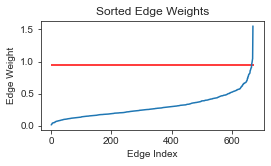

In [154]:
df_Collinder_69_new = min_span_tree(df_Collinder_69_new[df_Collinder_69_new['cluster']==0], 
                                    num_std=0, manual_th=True, threshold=.95)
# cmd_plotly(df_Collinder_69_new, 'bp_rp', 'phot_g_mean_mag', huex='MST_cluster', s=5)

573


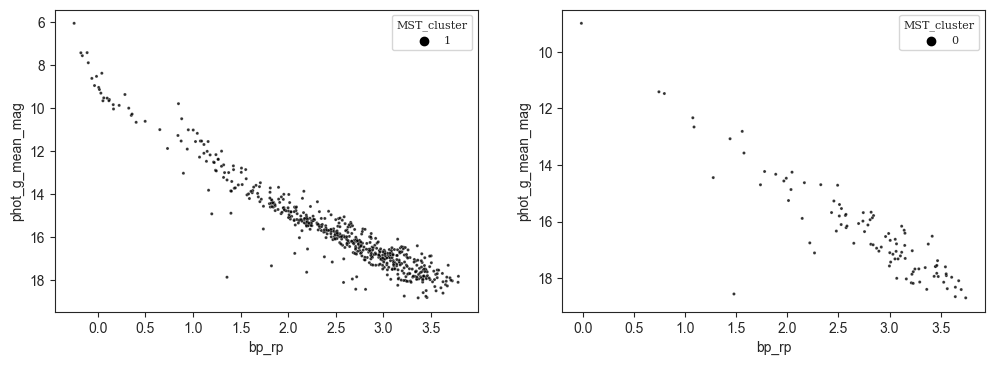

In [155]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=100)
print(len(df_Collinder_69_new[df_Collinder_69_new['MST_cluster']==1]))
cmd_plotly(df_Collinder_69_new[df_Collinder_69_new['MST_cluster']==1], 'bp_rp', 'phot_g_mean_mag', huex='MST_cluster', s=5, ax=axes[0])
cmd_plotly(df_Collinder_69_new[df_Collinder_69_new['MST_cluster']==0], 'bp_rp', 'phot_g_mean_mag', huex='MST_cluster', s=5, ax=axes[1])

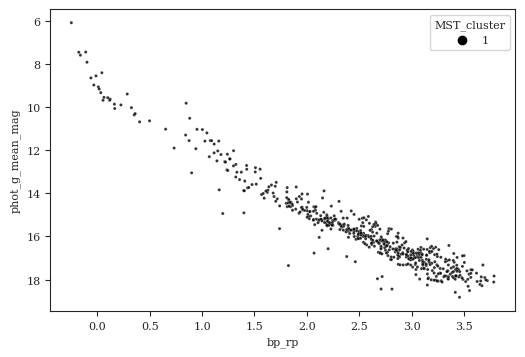

In [156]:
df_Collinder_69_cluster= df_Collinder_69_new[(df_Collinder_69_new['MST_cluster']==1)&(df_Collinder_69_new['prob']>=.8)]
cmd_plotly(df_Collinder_69_cluster, 'bp_rp', 'phot_g_mean_mag', huex='MST_cluster', s=5)

### Color excess plot

In [157]:
def black_body_plot(data, x_axis, y_axis, ax=None, alpha=0.8, s=8):
    
    with plt.style.context(['ieee']):
        if ax is None:
            fig = plt.figure(figsize=(4,4), dpi=100)
            ax = fig.add_subplot(111)
        sns.scatterplot(data=data, y=y_axis, x=x_axis, alpha=alpha, s=s, ax=ax, color='black')

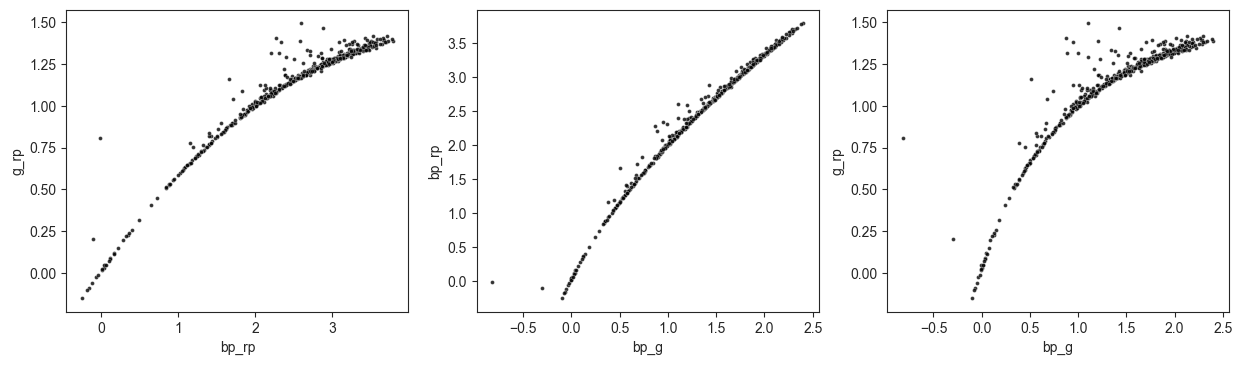

In [158]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4), dpi=100)
black_body_plot(df_Collinder_69_cluster, 'bp_rp', 'g_rp', ax=axes[0])
black_body_plot(df_Collinder_69_cluster, 'bp_g', 'bp_rp', ax=axes[1])
black_body_plot(df_Collinder_69_cluster, 'bp_g', 'g_rp', ax=axes[2])

### Color vs Mv

In [159]:
def color_exc_to_Gmg(data, x_axis = 'Gmg2', y_axis = 'bp_g', alpha=0.5, s=15, num_bins=10):
    # Define bin edges
    bins = np.linspace(data[x_axis].min(), data[x_axis].max(), num=num_bins)

    # Calculate bin statistics
    bin_means, bin_edges, binnumber = stats.binned_statistic(data[x_axis], data[y_axis], statistic='mean', bins=bins)
    bin_std, _, _ = stats.binned_statistic(data[x_axis], data[y_axis], statistic='std', bins=bins)

    # Scatter plot with error bars
    fig = plt.figure(figsize=(6,3), dpi=100)
    ax = fig.add_subplot(111)
    sns.scatterplot(data=data, y=y_axis, x=x_axis, alpha=alpha, s=s)
    plt.errorbar(bin_edges[:-1], bin_means, yerr=bin_std, fmt='^',
                alpha=alpha, color='r', ecolor='r', capsize=5, label='Mean ± Std')
    
    plt.legend()
    plt.grid(True)

In [160]:
# df_Collinder_69_cluster['Gmg2'] = df_Collinder_69_cluster['Gmg'] - (3.25 * .8 * df_Collinder_69_cluster['bp_g'])

# with plt.style.context(['ieee']):
#     color_exc_to_Gmg(df_Collinder_69_cluster, 'Gmg2', 'bp_g', num_bins=15)

### King Profile

In [161]:
def king_profile_function(x, f_b, f_0, R_c):
    return (f_b + (f_0 / (1 + (x/R_c)**2)))

def fit_king_profile(data, plotting = True, norm_density=False):
    """
    returns coefs: [f_b, f_0, R_c], R_t
    """
    
    center = (np.mean(data['ra']), np.mean(data['dec']))  # center of cluster
    max_r = round(max(np.linalg.norm(center - data[['ra', 'dec']], axis=1)), 2) + 0.01
    
    radii = np.linspace(0, max_r, 13)  # Define the radii of the concentric circles
    x = np.linspace(0, max_r, num=100)

    # star density
    star_densities = []  
    for i in range(len(radii) - 1):
        r_inner = radii[i]
        r_outer = radii[i + 1]

        # Calculate the distances between the center and each star's position
        distances = np.sqrt((data['ra'] - center[0])**2 + (data['dec'] - center[1])**2)

        # Count the number of stars within the current circle
        stars_within_circle = data[(distances >= r_inner) & (distances < r_outer)]
        star_count = len(stars_within_circle)

        # Calculate the area of the circle
        circle_area = np.pi * (r_outer**2 - r_inner**2)

        # Calculate the star density within the circle
        star_density = star_count / circle_area
        star_densities.append(star_density)

    star_densities = np.array(star_densities)

    # normal density 
    normal_densities = star_densities / np.linalg.norm(star_densities)
    
    if norm_density:
        star_densities = normal_densities

    # fitting data on king profile
    coefs, cov = curve_fit(king_profile_function, radii[:-1], star_densities, maxfev=5000)

    R_tidal = coefs[2]*np.sqrt(coefs[1]/(3*np.sqrt(cov[0,0]))-1)
    
    if plotting:
        with plt.style.context(['ieee']):
            # Plotting the density profile
            plt.figure(figsize=(5,3), dpi=100)
            plt.plot(radii[:-1], star_densities, 'o', ms=4)
            plt.plot(x, king_profile_function(x, coefs[0], coefs[1], coefs[2]), '--')
#             plt.title(convert_to_cluster_name(namestr(data, globals())[0]))
            plt.xlabel('Radius from Center')
            plt.ylabel('Star Density')
            plt.show()
    
    return coefs, R_tidal, cov

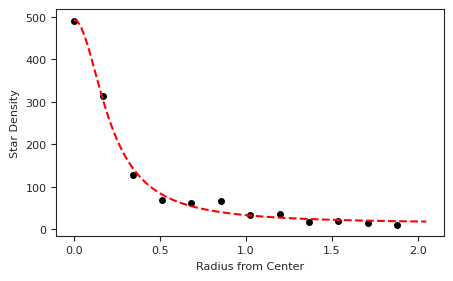

Collinder 69
f_b: 13.13 std: 5.38
f_0: 480.51
R_c: 0.21
R_t: 1.12


In [162]:
coefs, R_t, cov = fit_king_profile(df_Collinder_69_cluster, norm_density=False)

print('Collinder 69')
print("f_b:", round(coefs[0], 2), 'std:', round(np.sqrt(cov[0][0]), 2))
print("f_0:", round(coefs[1], 2))
print("R_c:", round(coefs[2], 2))
print('R_t:', round(R_t, 2))

In [163]:
center = (np.mean(df_Collinder_69_cluster['ra']), np.mean(df_Collinder_69_cluster['dec']))
distances = np.sqrt((df_Collinder_69_cluster['ra'] - center[0])**2 + (df_Collinder_69_cluster['dec'] - center[1])**2)
stars_within_circle = df_Collinder_69_cluster[(distances < coefs[2])]
stars_out_of_bound = df_Collinder_69_cluster[(distances > R_t)]

In [164]:
len(stars_within_circle)

72

In [165]:
len(stars_out_of_bound)

173

### Survey Collinder 69

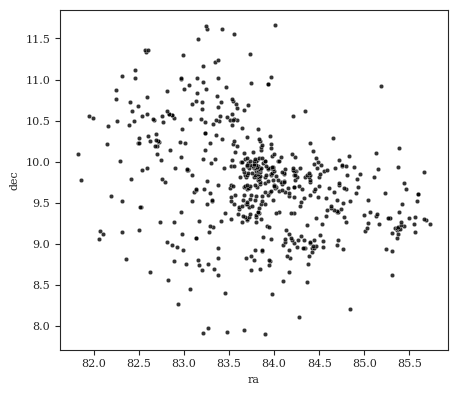

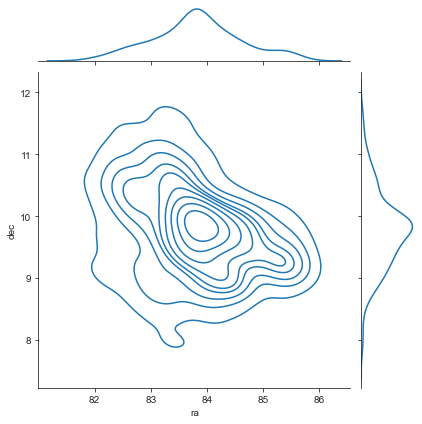

In [168]:
with plt.style.context(['ieee']):
    plt.figure(figsize=(5,4.5), dpi=100)
    sns.scatterplot('ra', 'dec', data=df_Collinder_69_cluster, s=10, alpha=.8);
sns.jointplot('ra', 'dec', data=df_Collinder_69_cluster, s=8, kind='kde');

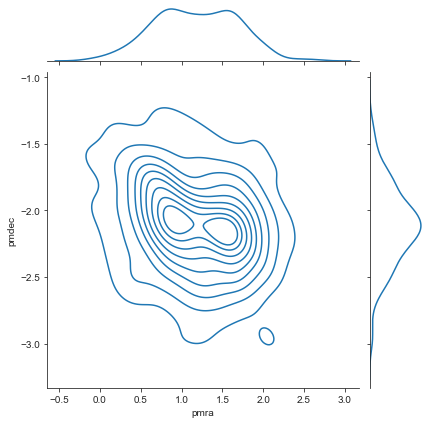

In [169]:
sns.jointplot('pmra', 'pmdec', data=df_Collinder_69_cluster, s=8, kind='kde');

In [170]:
df_Collinder_69_cluster['r_med_photogeo']

2      394.34680
3      390.70602
4      395.23773
6      396.86813
7      393.48343
         ...    
664    399.91806
665    394.61273
667    391.09283
668    389.92773
673    369.29608
Name: r_med_photogeo, Length: 551, dtype: float64

## Two Clusters

In [ ]:
### SAMPLE FROM MODEL

# X, y = model.sample(n_samples=1000)
# X = pd.DataFrame(X, columns=['pmra', 'ra', 'dec', 'parallax'])
# X['cluster'] = y

In [211]:
df, model = gassian_mixture(df_Collinder_69_cluster, parameters=['pmra', 'ra', 'dec', 'parallax'])
df = df[df['prob']>.8]

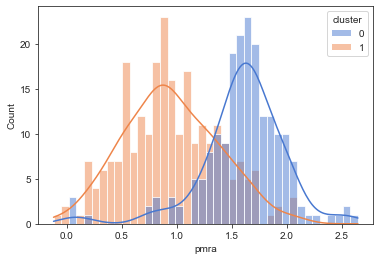

In [212]:
sns.histplot(data=df, x='pmra', hue='cluster', kde=True, bins=40, palette='muted');
# sns.histplot(data=df[(df['bp_rp']<.7)], x='pmra', hue='cluster', kde=True, bins=50, palette='Set1')
# plt.ylim(0,5)

245


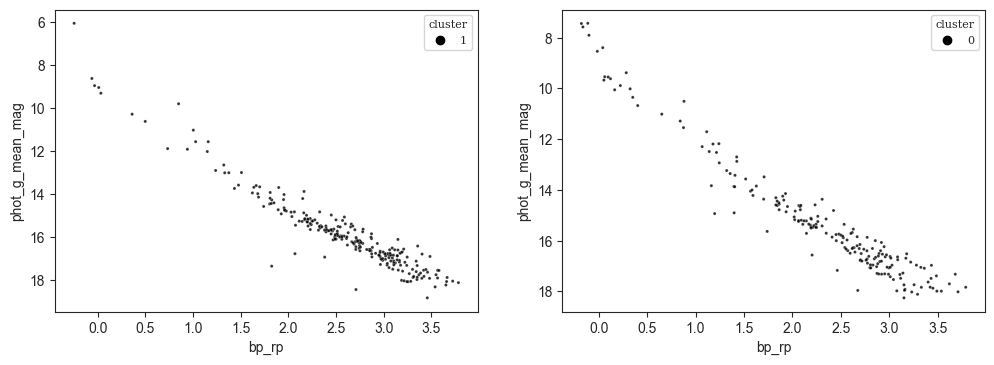

In [213]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=100)
print(len(df[df['cluster']==1]))
cmd_plotly(df[df['cluster']==1], 'bp_rp', 'phot_g_mean_mag', huex='cluster', s=5, ax=axes[0])
cmd_plotly(df[df['cluster']==0], 'bp_rp', 'phot_g_mean_mag', huex='cluster', s=5, ax=axes[1])

It seems that data points which their ***bp_rp*** is *under* **.7**, should be **1**

In [214]:
df[(df['bp_rp']<.7)][['pmra', 'pmdec', 'cluster']].groupby('cluster').count()

,pmra,pmdec
cluster,,
0,17,17
1,7,7


In below plot the assumption could be reasonable!

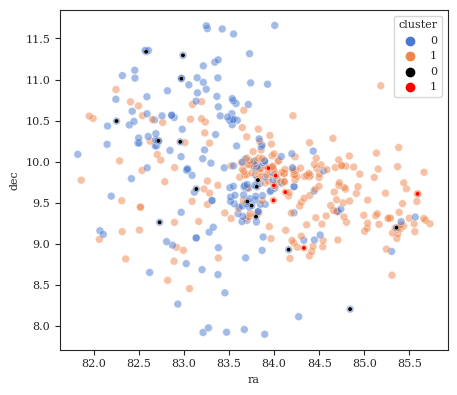

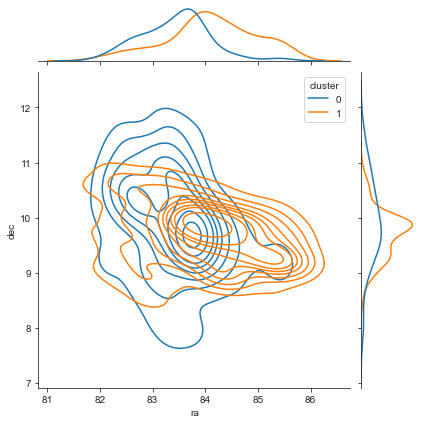

In [215]:
with plt.style.context(['ieee']):
    plt.figure(figsize=(5,4.5), dpi=100)
    sns.scatterplot('ra', 'dec', data=df, s=31, hue='cluster', palette='muted', alpha=.5)
    sns.scatterplot('ra', 'dec', data=df[(df['bp_rp']<.7)], s=10, hue='cluster');
sns.jointplot('ra', 'dec', data=df, s=8, kind='kde', hue='cluster');

but in pmra vs pmdec plot it is not reasonable

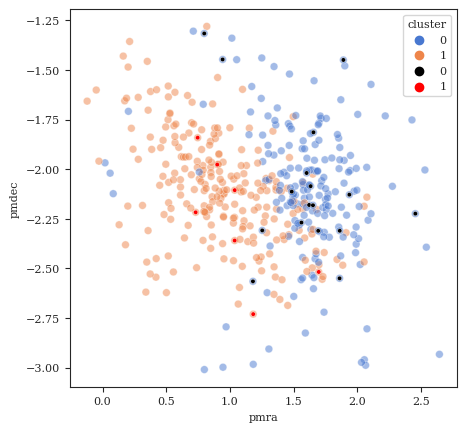

In [216]:
with plt.style.context(['ieee']):
    plt.figure(figsize=(5,5), dpi=100)
    sns.scatterplot('pmra', 'pmdec', data=df, s=31, hue='cluster', palette='muted', alpha=.5)
    sns.scatterplot('pmra', 'pmdec', data=df[(df['bp_rp']<.7)], s=10, hue='cluster');

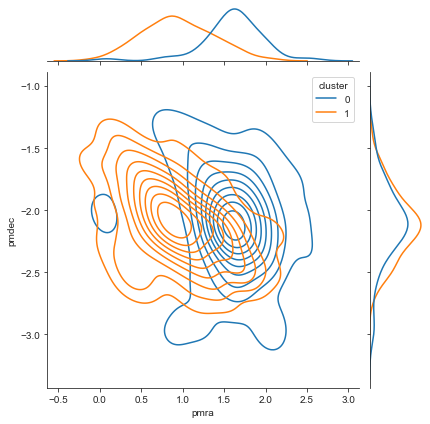

In [217]:
sns.jointplot('pmra', 'pmdec', data=df, s=8, hue='cluster', kind='kde');

In [218]:
%matplotlib inline

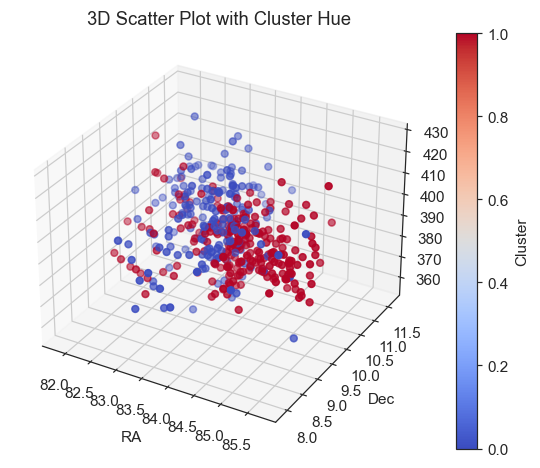

In [219]:
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D plot
fig = plt.figure(figsize=(7, 5), dpi=110)
ax = fig.add_subplot(111, projection='3d')

# Plot the scatter points with hue
scatter = ax.scatter(df['ra'], df['dec'], df['r_med_photogeo'], c=df['cluster'], cmap='coolwarm')

# Set labels and title
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.set_zlabel('r_med_geophot')
ax.set_title('3D Scatter Plot with Cluster Hue')

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Cluster')

# Display the plot
plt.show()

## Refinements

In [220]:
# plt.figure(figsize=(4,4), dpi=100)
# counts, bins, patches = plt.hist(data[column], bins = 30)

# # Define the Gaussian function
# def gaussian(x, amp, mu, sigma):
#     return amp * np.exp(-(x - mu)**2 / (2 * sigma**2))

# # data
# x_data = bins[:-1]
# y_data = counts

# # Fit the Gaussian function to the data
# popt, pcov = curve_fit(gaussian, x_data, y_data, maxfev=5000)

# plt.figure(figsize=(8,2), dpi=80)
# # Plot the original data and the fitted curve
# sns.scatterplot(x_data, y_data, label=column)
# plt.plot(x_data, gaussian(x_data, *popt), color='red', label='Fit')
# plt.legend()
# plt.show()

In [221]:
def gaussian(x, amp, mu, sigma):
    return amp * np.exp(-(x - mu)**2 / (2 * sigma**2))

In [222]:
def fit_gaussian_pmra(data):
    
    def gaussian(x, amp, mu, sigma):
        return amp * np.exp(-(x - mu)**2 / (2 * sigma**2))
    
    counts, bins = np.histogram(data['pmra'], bins=23)

    x_data = bins[:-1]
    y_data = counts

    # Fit the Gaussian function to the data
    popt, pcov = curve_fit(gaussian, x_data, y_data, maxfev=5000)

    plt.figure(figsize=(4,2), dpi=100)
    # Plot the original data and the fitted curve
    sns.scatterplot(x_data, y_data, label='pmra')
    plt.plot(x_data, gaussian(x_data, *popt), color='red', label='fit')
    plt.legend()
    plt.show()
    
    return popt

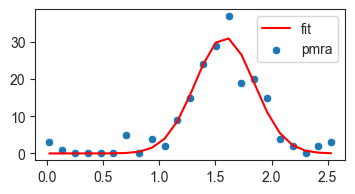

31.26 1.58 0.26
pmra upper bound: 2.37
pmra lower bound: 0.79
cluster length: 183


In [223]:
amp, mu, std = fit_gaussian_pmra(df[df['cluster'] == 0])
print(round(amp,2), round(mu,2), round(std,2))
df[df['cluster'] == 0] = guassian_filter(df[df['cluster']==0], 'pmra', mu, std)

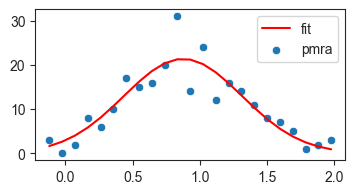

21.35 0.88 0.44
pmra upper bound: 2.2
pmra lower bound: -0.45
cluster length: 245


In [224]:
amp, mu, std = fit_gaussian_pmra(df[df['cluster'] == 1])
print(round(amp,2), round(mu,2), round(std,2))
df[df['cluster'] == 1] = guassian_filter(df[df['cluster']==1], 'pmra', mu, std)

In [326]:
df = df.dropna(axis=0)

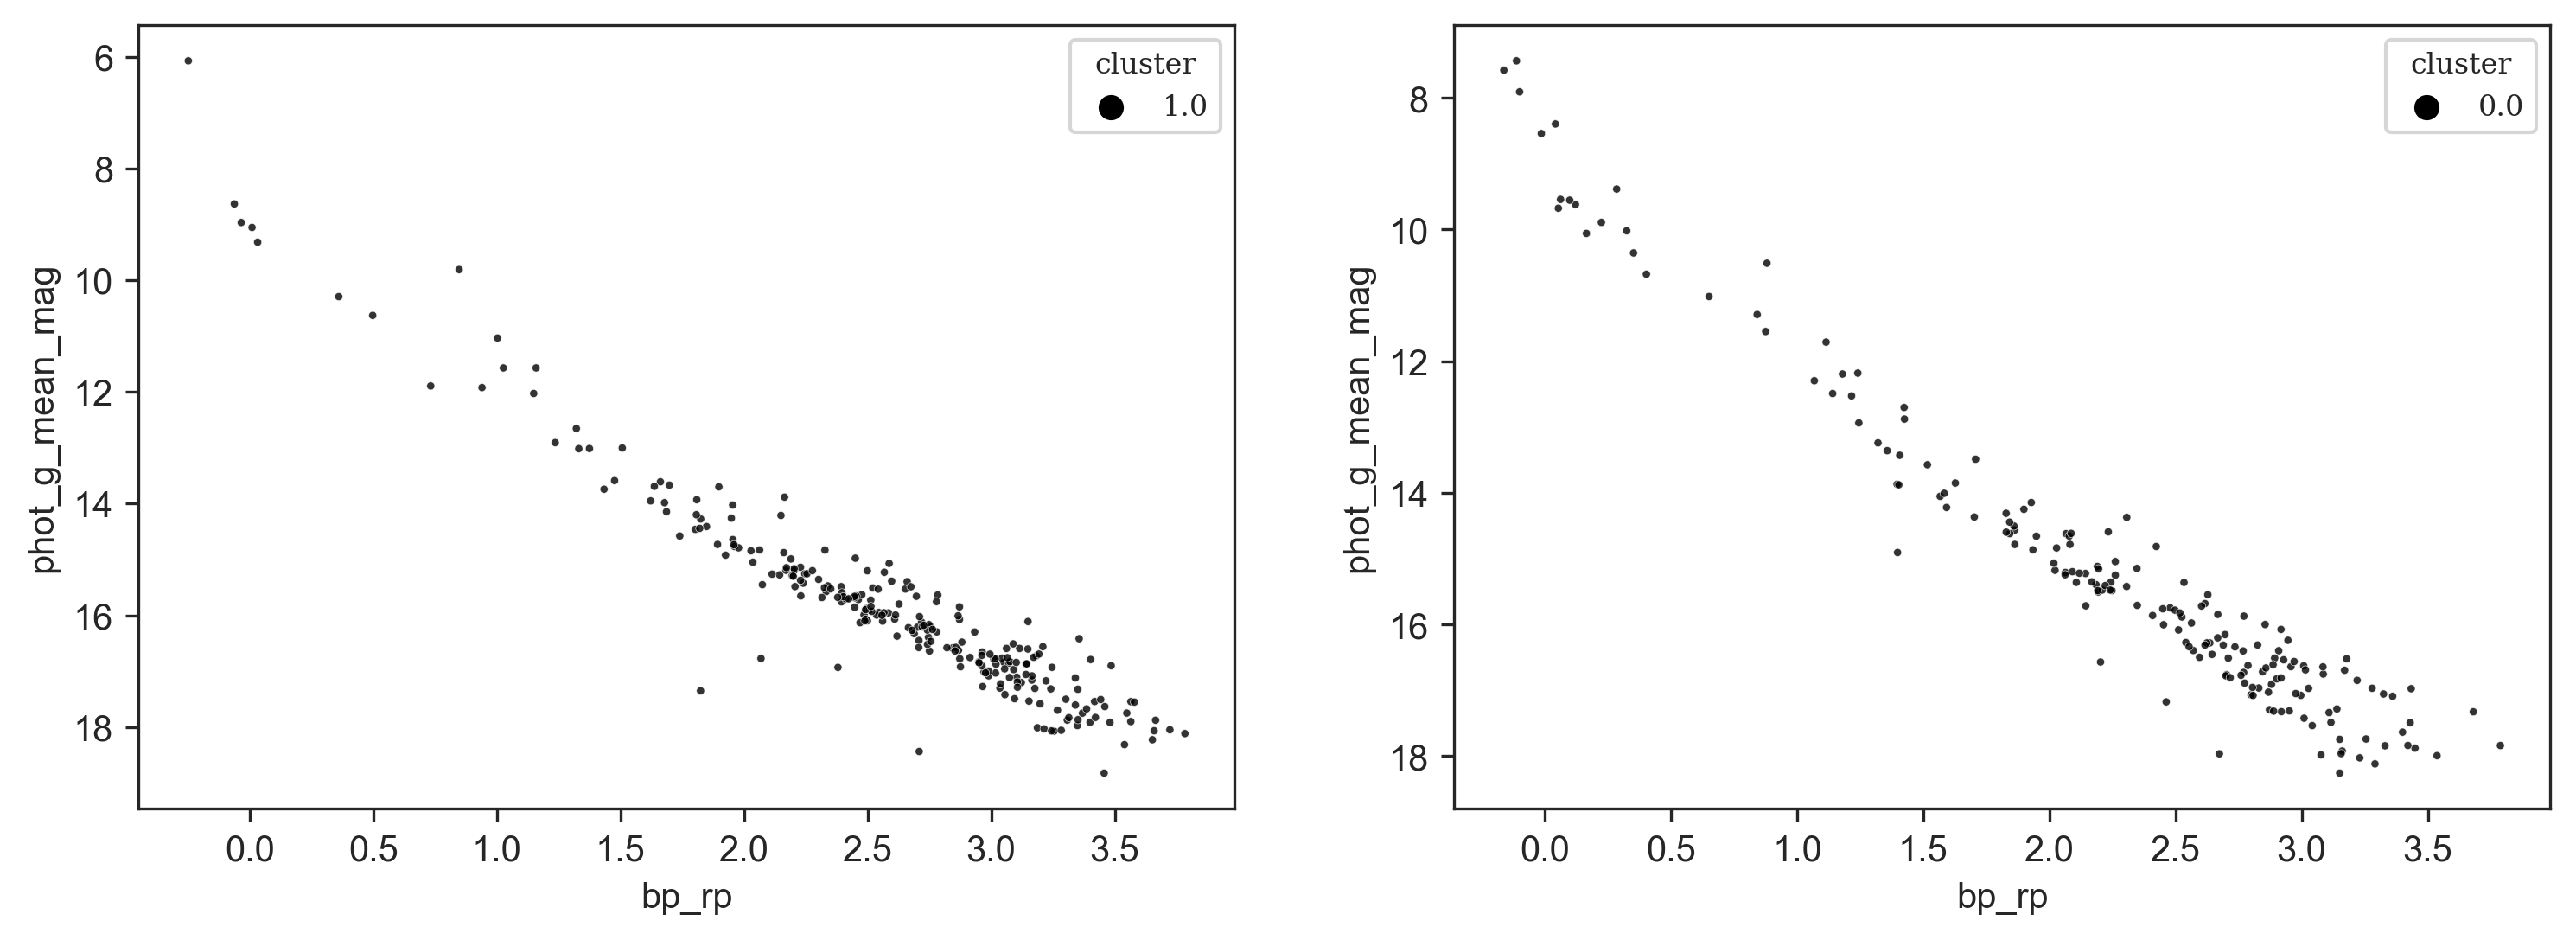

In [364]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=300)
# print(len(df[df['cluster']==1]))
cmd_plotly(df[df['cluster']==1], 'bp_rp', 'phot_g_mean_mag', huex='cluster', s=5, ax=axes[0])
cmd_plotly(df[df['cluster']==0], 'bp_rp', 'phot_g_mean_mag', huex='cluster', s=5, ax=axes[1])

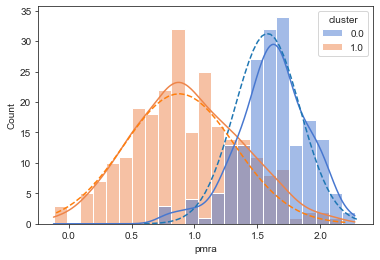

In [394]:
# Plot the histogram
hist = sns.histplot(data=df, x='pmra', hue='cluster', kde=True, bins=23, palette='muted')    
x1 = np.linspace(-.1,2.2)
x2 = np.linspace(.6, 2.3)
plt.plot(x2, gaussian(x2, 31.26, 1.58, 0.26), '--')
plt.plot(x1, gaussian(x1, 21.35, 0.88, 0.44), '--');

In [322]:
def double_guassina(x, amp_1, mu_1, sigma_1, amp_2, mu_2, sigma_2):
    return (amp_2 * np.exp(-(x - mu_2)**2 / (2 * sigma_2**2))) + (amp_1 * np.exp(-(x - mu_1)**2 / (2 * sigma_1**2)))

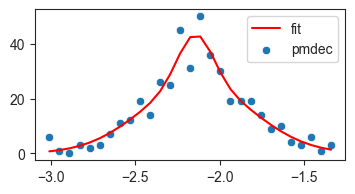

In [349]:
counts, bins = np.histogram(df['pmdec'], bins=29)

x_df = bins[:-1]
y_df = counts

# Fit the Gaussian function to the df
popt, pcov = curve_fit(double_guassina, x_df, y_df, maxfev=5000)

plt.figure(figsize=(4,2), dpi=100)
# Plot the original df and the fitted curve
sns.scatterplot(x_df, y_df, label='pmdec')
plt.plot(x_df, double_guassina(x_df, *popt), color='red', label='fit')
plt.legend()
plt.show()

In [353]:
print(np.round(popt[:3],2))
print(np.round(popt[3:],2))

[25.29 -2.14 -0.33]
[18.03 -2.14 -0.1 ]


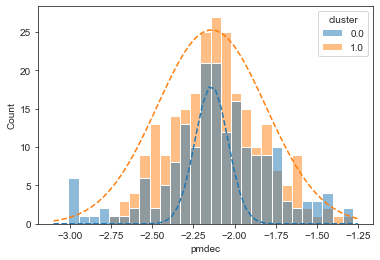

In [399]:
sns.histplot(data=df, x='pmdec', bins=28, hue='cluster', kde=False)
x = np.linspace(-3.1,-1.25)
plt.plot(x, gaussian(x, 18.03, -2.14, -0.1 ), '--')
plt.plot(x, gaussian(x, 25.29, -2.14, -0.33), '--');

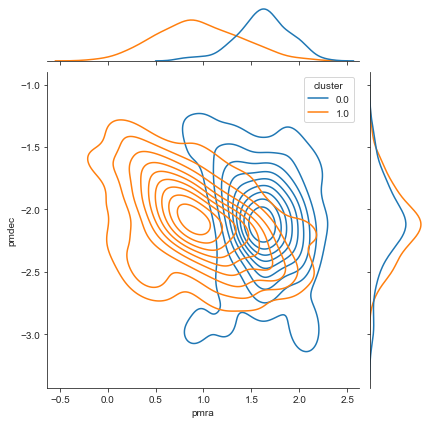

In [363]:
sns.jointplot('pmra', 'pmdec', data=df, s=8, hue='cluster', kind='kde');

In [337]:
df = df_Collinder_69_cluster.merge(df_Collinder_69[['ra', 'teff_gspphot']], how='left').dropna(axis=0)
df = df.merge(df_Collinder_69[['ra', 'L']], how='left').dropna(axis=0)

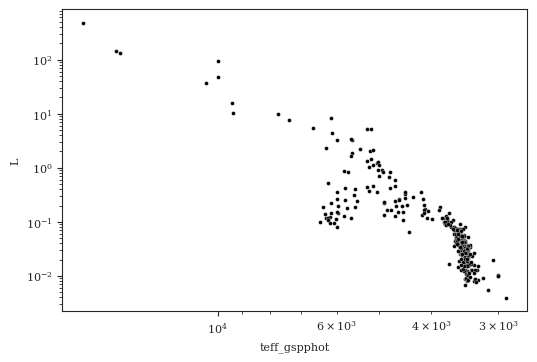

In [338]:
with plt.style.context(['ieee']):
    plt.figure(figsize=(6,4), dpi=100)
    sns.scatterplot(data=df, x='teff_gspphot', y='L', s=8)
    plt.xscale('log')
    plt.yscale('log')
    plt.gca().invert_xaxis()